# Aula 2: Predição Linear no CartPole-v1

## Introdução
Neste segundo notebook vamos aprender como melhorar um aproximador paramétrico $Q_\phi(\mathbf{s, a})$ de forma a 
melhor aproximar a função valor-ação de uma data política estocástica $\pi(\mathbf{a} | \mathbf{s})$. Isso é conhecido 
como o problema de _predição aproximada_ em aprendizado por reforço.

<center>
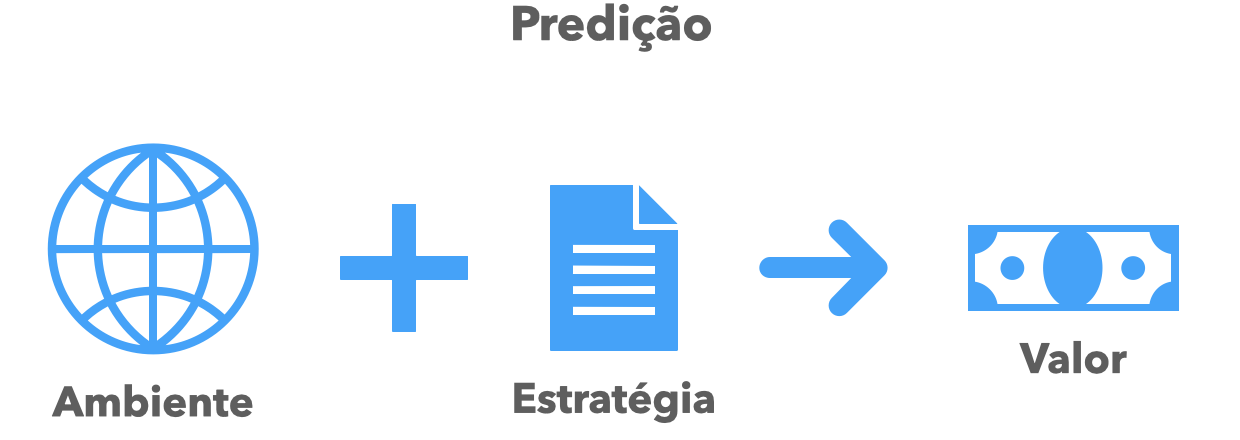
</center>

## Objetivos
* Entender a abordagem de predição aproximada como busca do espaço de parâmetros do aproximador
* Familiarizar-se com a abordagem do Sonnet para encapsular aproximadores e seus parâmetros
* Implementar uma função custo apropriada para diferenciação automática em TensorFlow
* Combinar coleta de dados e treinamento via gradiente descendente estocástico para realizar predição aproximada

### Imports
> **Atenção**: não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial. 

In [1]:
%matplotlib inline
import os.path as osp
from abc import ABC
from abc import abstractmethod
from collections import deque
from datetime import datetime
from typing import Callable
from typing import Dict
from typing import List
from typing import Iterable
from typing import Optional
from typing import Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_probability as tfp
from gym.spaces import Box
from gym.spaces import Discrete
from gym.spaces import Space
from gym.wrappers import TimeAwareObservation
from tqdm.notebook import trange

from utils.cem import BinaryActionLinearPolicy
from utils.cem import get_cem_policy
from utils.gym_util import TimeAwareWrapper
from utils.logging.tf_logger import TFLogger
from utils.replay.replay import ReplayBuffer as TransitionDataset
from utils.tf_utils import create_variables
from utils.tf_utils import set_tf_allow_growth
from utils.viz.viz_prediction import display_frames_and_q_values


TensorDict = Dict[str, tf.Tensor]
set_tf_allow_growth()

---
## Ambiente

<center>
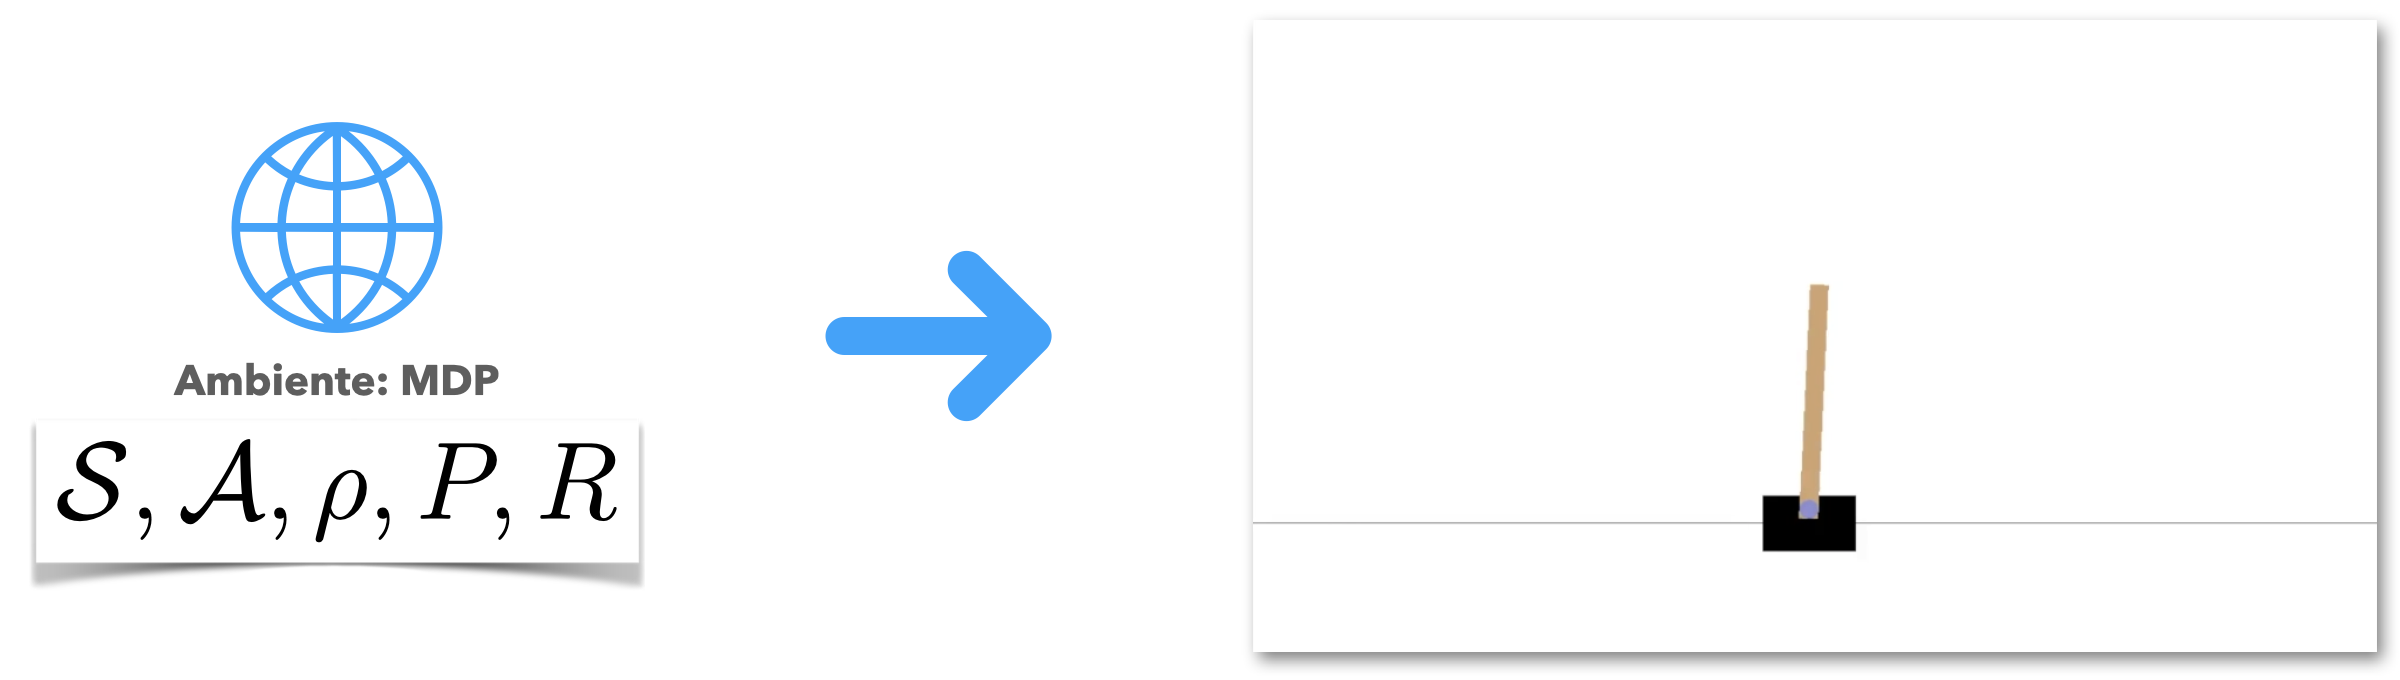
</center>

O primeiro componente em um problema de Predição é o ambiente. Nessa aula usaremos o simulador `CartPole-v0`. Recapitulando os últimos slides da aula 2, o objetivo do agente é manter o poste equilibrado, suas ações movem o carrinho para a esquerda ou direita ($\mathcal{A} = \{ \leftarrow, \rightarrow \}$), e os estados são vetores ($\mathcal{S} \subset \mathbb{R}^4$) cujas entradas representam:
1. posição horizontal do centro do carrinho;
2. velocidade horizontal do carrinho;
3. ângulo do poste com a vertical; e
4. velocidade angular do poste.

A recompensa em `CartPole-v0` é sempre `1.0` ($R(\mathbf{s, a}) = 1$) e o limite de tempo da tarefa é de 200 passos de tempo. Ou seja, o retorno de uma política será proporcional ao tempo que a mesma consegue manter o poste equilibrado, com um limite de 200.

> **Atenção**: estamos adicionando o tempo relativo como uma quinta variável de estado, i.e., uma variável indicando de 0 a 200 passos normalizada entre 0 e 1. Isto não tem grande impacto na política (é possível aprender uma política ótima cega ao tempo atual), mas é crucial para que a função valor diferencie estados iniciais, intermediários e finais. Detalhes da implementação na classe `TimeAwareWrapper`.

In [2]:
env = TimeAwareWrapper(gym.make("CartPole-v0"))

---
## Obtendo a política para avaliação

<center>
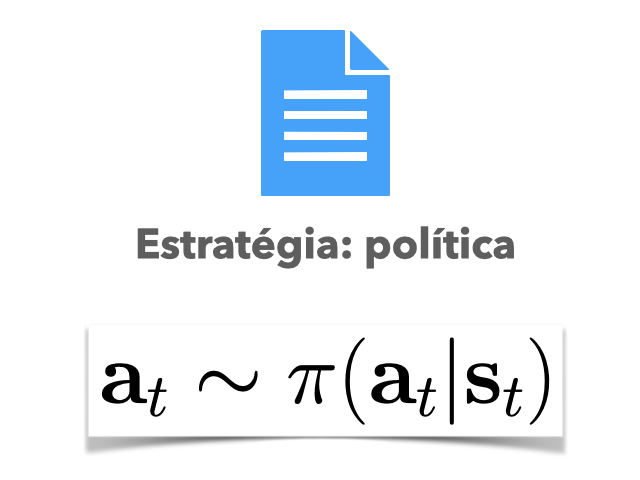
</center>

Aqui definimos a interface geral de políticas para avaliação. A classe `Policy` abstrai as principais características de uma política
* Armazena o `observation_space` e `action_space` com os quais está interagindo
* Retorna uma ação em forma de `tf.Tensor` ao ser chamada com uma observação (estado) de entrada

É importante que a política retorne um `tf.Tensor` ao ser chamada para que possa ser usada na definição de funções custo/objetivo, as quais precisam ser em `tensorflow` para aproveitarmos sua diferenciação automática.

In [3]:
class Policy(ABC):
    """Uma política de RL para interação com o ambiente e funções custo.
    
    Args:
        observation_space: espaço de observações do ambiente
        action_space: espaço de ações do ambiente
    """
    
    def __init__(self, observation_space: Space, action_space: Space, **kwargs):
        super().__init__(**kwargs)
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def __call__(self, obs: tf.Tensor) -> tf.Tensor:
        """Amostra uma ação dada a observação.
        
        Args:
            obs: batch de observações
            
        Returns:
            Um batch de ações
        """


class UniformRandomPolicy(Policy):
    """Política que amostra ações uniformemente ao acaso."""

    def __init__(self, observation_space: Space, action_space: Discrete):
        assert_discrete(action_space, self)
        super().__init__(observation_space, action_space)

    def __call__(self, obs: tf.Tensor) -> tf.Tensor:
        batch_size = tf.shape(obs)[0]
        action_dim = self.action_space.n
        action_tensor = tf.random.uniform(shape=(batch_size,), minval=0, maxval=action_dim, dtype=tf.int32)

        return action_tensor
    

class HandCraftedCartPolePolicy(Policy):
    """Política que escolhe 'esquerda' com o posto inclinado à esquerda e 'direita' caso contrário."""

    def __call__(self, obs: tf.Tensor) -> tf.Tensor:
        action_tensor = tf.where(
            obs[..., 2] < 0,  # angulo do poste
            tf.zeros_like(obs[..., 2], dtype=tf.int32),  # escolhe esquerda
            tf.ones_like(obs[..., 2], dtype=tf.int32)  # escolhe direita
        )
        return action_tensor


class CEMPolicy(Policy):
    """Política que encapsula outra devolvida pelo Cross-Entropy Method."""
    def __init__(self, *args, cem_policy: BinaryActionLinearPolicy, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = tf.convert_to_tensor(cem_policy.weight, dtype=tf.float32)
        self.bias = tf.convert_to_tensor(cem_policy.bias, dtype=tf.float32)
        
    def __call__(self, obs: tf.Tensor) -> tf.Tensor:
        # de vetor (...xn) para vetor coluna (...xnx1)
        obs = tf.expand_dims(obs, axis=-1)
        score = self.weight @ obs + self.bias
        # de matrix 1x1 para escalar
        act = score[..., 0, 0] < 0
        act = tf.cast(act, dtype=tf.int32)
        return act

Durante esta aula, avaliaremos uma política ótima retornada pelo método CEM. Como o foco da aula é o aprendizado funções valor, usaremos CEM como um a função caixa-preta apenas para fornecer uma política para avaliação.

> Sinta-se à vontade para inspecionar o código de `utils.cem` mais tarde para aprender mais sobre o método

In [4]:
policy = CEMPolicy(
    env.observation_space, 
    env.action_space, 
    cem_policy=get_cem_policy(env, n_iter=20, seed=42, notebook=True)
)

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration  0. Episode mean reward:  15.280
Iteration  1. Episode mean reward:  44.160
Iteration  2. Episode mean reward:  49.400
Iteration  3. Episode mean reward:  77.920
Iteration  4. Episode mean reward:  93.880
Iteration  5. Episode mean reward: 166.640
Iteration  6. Episode mean reward: 174.160
Iteration  7. Episode mean reward: 181.480
Iteration  8. Episode mean reward: 199.920
Iteration  9. Episode mean reward: 190.160
Iteration 10. Episode mean reward: 200.000
Iteration 11. Episode mean reward: 200.000
Iteration 12. Episode mean reward: 192.840
Iteration 13. Episode mean reward: 200.000
Iteration 14. Episode mean reward: 200.000
Iteration 15. Episode mean reward: 200.000
Iteration 16. Episode mean reward: 200.000
Iteration 17. Episode mean reward: 200.000
Iteration 18. Episode mean reward: 200.000
Iteration 19. Episode mean reward: 200.000


---
## Aproximador linear da função valor

<center>
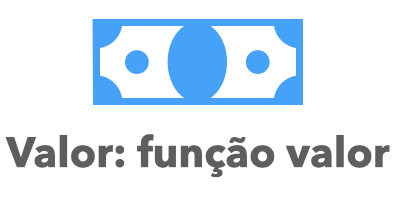
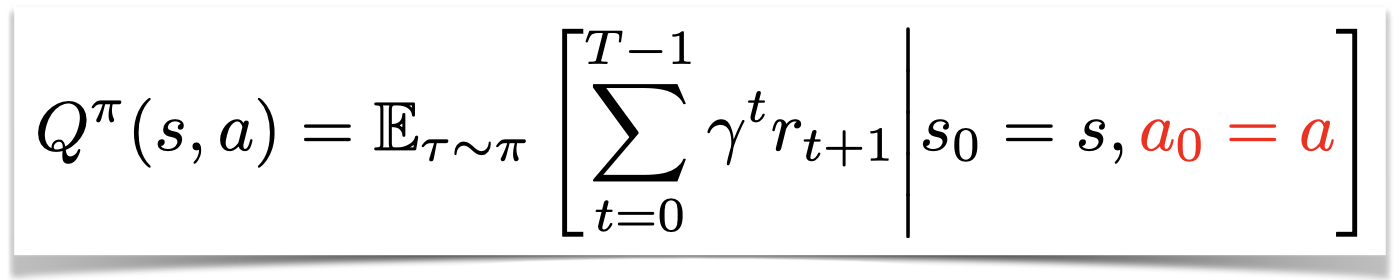
</center>

Acima temos a definição da função ação-valor real de uma política.

Essa função é complicada. Ela envolve uma esperança sobre todas as possíveis futuras trajetórias e seus retornos.

Como não temos acesso a essa função, devemos aprendê-la através de dados coletados pela política.

Como visto em aula e acima, o `CartPole` tem espaço infinito de estados. Logo, não conseguimos armazenar ou atualizar
estimativas $Q(\mathbf{s, a})$ para cada par estado-ação.

Nossa abordagem aqui envolve aprender um aproximador de função paramétrico $Q_\phi: \mathcal{S} \times \mathcal{A} \mapsto \mathbb{R}$ linear:

$$
    \phi = 
    \begin{bmatrix}
        \phi_\leftarrow \\
        \phi_\rightarrow
    \end{bmatrix}
    \, \quad
    \phi_\leftarrow, \phi_\rightarrow \in \mathbb{R}^4
$$

$$
    Q_\phi(\mathbf{s}, \leftarrow) = \phi_\leftarrow^\intercal \mathbf{s} \\
    Q_\phi(\mathbf{s}, \rightarrow) = \phi_\rightarrow^\intercal \mathbf{s}
$$

A biblioteca Sonnet da DeepMind disponibiliza a classe `Module`, que nos ajudará a encapsular o aproximador como uma função diferenciável nos
parâmetros.

In [5]:
snt.Module?

Init signature: snt.Module(*args, **kwargs) -> ~T
Docstring:     
Base class for Sonnet modules.

A Sonnet module is a lightweight container for variables and other modules.
Modules typically define one or more "forward" methods (e.g. ``__call__``)
which apply operations combining user input and module parameters. For
example::

    >>> class MultiplyModule(snt.Module):
    ...   def __call__(self, x):
    ...     if not hasattr(self, 'w'):
    ...       self.w = tf.Variable(2., name='w')
    ...     return x * self.w

    >>> mod = MultiplyModule()
    >>> mod(1.)
    <tf.Tensor: ... numpy=2.0>

Sonnet modules are a layer on top of :tf:`Module`, implementing automatic name
scoping as described in the original RFC :cite:`agarwal2019stateful`.
Init docstring:
Initializes the current module with the given name.

Subclasses should call this constructor before creating other modules or
variables such that those modules are named correctly.

Args:
  name: An optional string name for the cla

### Implementando a computação dos valores-ação
O módulo `Linear` do Sonnet implementa transformações afins da seguinte maneira
$$
    \text{Linear}(\mathbf{x}) = \mathbf{W}\mathbf{x} + \mathbf{b}
$$
onde
$\mathbf{x} \in \mathbb{R}^n$, $\mathbf{W} \in \mathbb{R}^{m\times n}$ e $\mathbf{b} \in \mathbb{R}^m$.
Logo, podemos implementar $Q_\phi(\mathbf{s}, \cdot)$ usando `Linear` da seguinte forma
$$
   \mathbf{W} =
   \begin{bmatrix}
       \phi_\leftarrow^\intercal \\
       \phi_\rightarrow^\intercal
   \end{bmatrix}
   \,, \quad
   \mathbf{b} = \mathbf{0}
   \,.
$$
Assim,
$$
    \text{Linear}(\mathbf{s}) = \mathbf{W}\mathbf{s} + \mathbf{b} =
    \begin{bmatrix}
        Q_\phi(\mathbf{s}, \leftarrow) \\
        Q_\phi(\mathbf{s}, \rightarrow)
    \end{bmatrix}
$$

> **Atenção**: embora possamos fixar $\mathbf{b} = \mathbf{0}$ (chamado 'bias'), é interessante torná-lo mais um parâmetro em tarefas com retornos não centralizados em zero, como no CartPole.

<!-- > Typically, the number of weights (the dimensionality of $\mathbf{w}$) is much less than the number of states ($d \ll |\mathcal{S}|$), and changing one weight changes the estimated value of many states. Consequently, when a single state is updated, the change generalizes from that state to affect the values of many other states. -->

In [6]:
# Declaramos a dimensionalidade da saída e deixamos Linear inferir a dimensionalidade da entrada
linear = snt.Linear(output_size=2)
obs = env.observation_space.sample()
print("Obs:", obs)
linear(obs[None])[0]

Obs: [-2.062007    0.19292748 -0.0336288   0.18557493  0.9864902 ]


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.7091115, -0.4439317], dtype=float32)>

### Extraindo características mais complexas do estado

Embora a abordagem acima funcione, a capacidade do aproximador resultante de representar diferentes funções do estado é limitada.

Para aumentar a flexibilidade do nosso aproximador, podemos usar uma função de extração de características do estado,
$f: \mathcal{S} \mapsto \mathbb{R}^n$, e definir nossa função linear sobre essas características:
$$
    \text{Linear}(f(\mathbf{s})) = \mathbf{W}f(\mathbf{s}) + \mathbf{b} =
    \begin{bmatrix}
        Q_\phi(f(\mathbf{s}), \leftarrow) \\
        Q_\phi(f(\mathbf{s}), \rightarrow)
    \end{bmatrix}
$$
Mais a diante veremos exemplos de diferentes funções desse tipo (chamadas funções de _features_) e seu impacto no aprendizado.

### Compilando tudo em um módulo do Sonnet

A seguinte classe implementa as ideias acima como um módulo do Sonnet, deixando o usuário escolher a função de _features_, que por padrão é a identidade, $f(\mathbf{s}) = \mathbf{s}$.

In [7]:
def assert_continuous(space: Space, client, nome: str = "observação"):
    assert isinstance(space, Box), f"{type(client)} requer espaço de {nome} contínuo"
    
def assert_discrete(space: Space, client, nome: str = "ação"):
    assert isinstance(space, Discrete), f"{type(client)} requer espaço de {nome} discreto"

In [8]:
class LinearQFunction(snt.Module):
    """Aproximador paramétrico de uma função valor-ação.
    
    Os valores para cada par estado-ação são computados como uma combinação linear de
    características do estado extraídas for uma função de features.
    
    Args:
        observation_space: o espaço de observações do ambiente
        action_space: o espaço de ações do ambiente
        features: função para extração de características do estado. Por padrão,
            devolve o próprio vetor de estados (função identidade)
        name: nome do aproximador
    """
    def __init__(
        self, observation_space: Box, action_space: Discrete, features: Callable[[tf.Tensor], tf.Tensor] = lambda s: s, 
        name: str = "LinearQ"
    ):
        super().__init__(name=name)

        assert_continuous(observation_space, self)
        assert_discrete(action_space, self)
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.features = features
        self.linear = snt.Linear(output_size=action_space.n, with_bias=True, name="QValues")

    @tf.function
    def __call__(self, obs: tf.Tensor) -> tf.Tensor:
        """Valores-ação computados como uma função linear em features do estado"""
        return self.linear(self.features(obs))
    
    @tf.function
    def action_values(self, obs: tf.Tensor, act: tf.Tensor) -> tf.Tensor:
        """Valor para uma ação específica.
        
        Útil quando não precisamos do valor de outra ação no mesmo estado.
        Assume que a primeira dimensão de `obs` corresponde ao batch.
        """
        batch_size = tf.shape(obs)[0]
        indices = tf.stack([tf.range(batch_size, dtype=act.dtype), act], axis=-1)
        q_values = tf.gather_nd(self(obs), indices) # (B,)
        return q_values

## Função custo

Recorde o objetivo de mimização com respeito aos parâmetros do nosso aproximador $Q_\phi(\mathbf{s}, \mathbf{a})$,
$$
    \mathcal{L}(\phi) = \mathbb{E}_{
        \substack{
            \mathbf{s}, \mathbf{a} \sim \pi \\
            \mathbf{s'} \sim P(\cdot|\mathbf{s}, \mathbf{a}) \\
            \mathbf{a'} \sim \pi(\cdot|\mathbf{s'})
        }
    } 
    \left[
        \left(
            R(\mathbf{s}, \mathbf{a}) + \gamma Q_\phi(\mathbf{s'}, \mathbf{a'}) - Q_\phi(\mathbf{s}, \mathbf{a})
        \right)^2
    \right]
    \,.
$$

Vamos focar por enquanto na expressão dentro de colchetes, i.e., assumindo que $\mathbf{s, a}, r, \mathbf{s', a'}$ vêm da distribuição correta.

Dito isso, implementaremos a função custo em TensorFlow para utilizarmos sua diferenciação automática. Isto é, dado $\mathcal{L}(\phi)$, Tensorflow automaticamente nos dará meios para calcular $\nabla\mathcal{L}(\phi)$.

Alguns pontos importantes sobre `loss_fn`:
* $R(\mathbf{s}, \mathbf{a}) + \gamma Q_\phi(\mathbf{s'}, \mathbf{a'})$ é uma aproximação por bootstrapping do alvo de regressão
  * Não queremos que o TensorFlow consideres o gradiente de $Q_\phi(\mathbf{s'}, \mathbf{a'})$ com respeito a $\phi$
  * Utilizaremos `tf.stop_gradient` para evitar isso
* Por desconsideramos o gradiente de $Q(s',a')$ estamos definindo um semi-gradiente
* `prediction_loss` é uma aproximação empírica de $\mathcal{L}(\phi)$ via amostras contidas no `batch`

**Exercício**: Implemente na função abaixo o cálculo dos valores preditos $Q_\phi(\mathbf{s, a})$ e o alvo de diferença temporal $Q_\phi(\mathbf{s', a'})$ como `q_values` e `q_targets` respectivamente. (**Dica**: utilize `q_func.action_values` para calcular o valor de ações)

> **Atenção**: utilizamos uma _closure_ `make_loss_fn` para produzir uma função (`loss_fn`) atrelada ao aproximador (`q_func`) e política (`policy`) passados
como argumento. Isso nos permite 'compilar' `loss_fn` via `tf.function`, tornando o cálculo do custo mais eficiente. Ademais, não precisaremos passar `q_func`, `policy` e `gamma` toda hora para `loss_fn`, apenas o _minibatch_ atual.

In [9]:
def make_loss_fn(q_func: LinearQFunction, policy: Policy, gamma: float) -> Callable[[TensorDict], tf.Tensor]:
    @tf.function
    def loss_fn(batch: TensorDict) -> tf.Tensor:
        obs = batch["obs"]
        actions = batch["action"]
        rewards = batch["reward"]
        next_obs = batch["next_obs"]
        terminals = tf.cast(batch["terminal"], tf.float32)

        ### SEU CODIGO AQUI ###
        # Valores preditos pelo aproximador para (s, a)
        q_values = q_func.action_values(obs, actions)

        # Alvos de diferença temporal: r + \gamma Q(s',a'). Note que usamos a política para a'
        next_actions = policy(next_obs)
        next_q_values = q_func.action_values(next_obs, next_actions)
        q_targets = rewards + (1 - terminals) * gamma * next_q_values # (B,)
        ### ###

        # Erro quadrático médio
        # Note que usamos `stop_gradient` nos valores alvo
        loss = tf.reduce_mean((tf.stop_gradient(q_targets) - q_values) ** 2)
        return loss
    
    return loss_fn

## Função de atualização

<center>
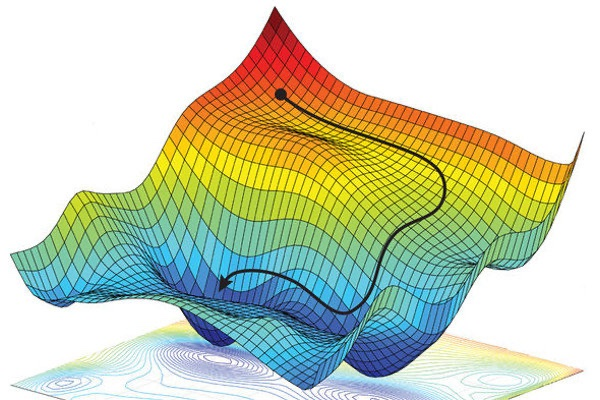
</center>

Para treinar o aproximador utilizaremos um método de otimização baseado na técnica de [Gradiente Descendente](https://en.wikipedia.org/wiki/Gradient_descent):
$$
    \phi \gets \phi - \alpha \nabla\mathcal{L}(\phi)
$$

Definimos a função custo, $\mathcal{L}(\phi)$, que queremos minimizar anteriormente. Agora temos que usar o TensorFlow para computar o gradiente
dessa função em relação aos parâmetros $\phi$ de $Q_\phi$.

Isso é feito via a classe `tf.GradientTape`, e já está implementado para você na função `update_fn` abaixo.

Note que `make_update_fn` recebe a função custo (`loss_fn`), e os parâmetros (`trainable_variables`) com respeito aos quais o gradiente será 
calculado.

Por fim, precisamos implementar a regra de atualização dos parâmetros que utiliza o gradiente do custo.
Isso será feito através de um otimizador (`optimizer`). O otimizador aplica o gradiente aos parâmetros, calculando a taxa de aprendizado
via estatísticas mantidas durante o treinamento, via `optimizer.apply(grads, trainable_variables)`.

Nessa parte prática optamos por usar um dos otimizadores mais utilizados em aprendizado por máquina, o [Adam](https://sonnet.readthedocs.io/en/latest/api.html#adam).

<!-- * Explicar o que são otimizadores estocásticos
  * Explicar que assumem um problema de minimização de função
  * Explicar a vantagem de não ter que escolher taxa de aprendizagem
  * Explicar que Adam foi especialmente desenhado para lidar com problemas estocásticos
  * Descrever em LaTex a regra de atualizacao dos parâmetros com Adam encapsulando o gradiente da função custo
  * Adicionar um GIF do trabalho acima mostrando o caminho dos parametros na superficie de uma funcao
   -->


> **IMPORTANTE**: não precisaremos implementar o algoritmo de gradiente descendente, isto é, o otimizador irá se encarregar disso para nós!
> 
> **Observação**: a bilioteca do Sonnet conta com inúmeros outros otimizadores (vide [documentação](https://sonnet.readthedocs.io/en/latest/api.html#module-sonnet.optimizers)). Uma apresentação mais detalha desses otimizadores está fora do escopo desse curso. Para aqueles interessados em aprender sobre otimizadores, sugerimos o tutorial disponível em https://ruder.io/optimizing-gradient-descent/.

In [10]:
def make_update_fn(
    loss_fn: Callable[[TensorDict], tf.Tensor], trainable_variables: Iterable[tf.Tensor], learning_rate: float
) -> Callable[[TensorDict], Tuple[tf.Tensor, TensorDict]]:
    optimizer = snt.optimizers.Adam(learning_rate)

    @tf.function
    def update_fn(batch: TensorDict) -> Tuple[tf.Tensor, tf.Tensor]:
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(trainable_variables)
            loss = loss_fn(batch)

        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply(grads, trainable_variables)

        grads_and_vars = {var.name: (grad, var) for grad, var in zip(grads, trainable_variables)}

        return loss, grads_and_vars
    
    return update_fn

---
## Coleta de experiências

Recorde nosso objetivo de otimização,
$$
    \min_\phi \mathbb{E}_{
        \substack{
            \mathbf{s}, \mathbf{a} \sim \pi \\
            \mathbf{s'} \sim P(\cdot|\mathbf{s}, \mathbf{a}) \\
            \mathbf{a'} \sim \pi(\cdot|\mathbf{s'})
        }
    } 
    \left[
        \left(
            R(\mathbf{s}, \mathbf{a}) + \gamma Q_\phi(\mathbf{s'}, \mathbf{a'}) - Q_\phi(\mathbf{s}, \mathbf{a})
        \right)^2
    \right]
    \,.
$$
É importante notar que a esperança acima é definida sobre estados e ações iniciais sob a distribuição induzida pela política
* Para amostrar dessa distribuição, devemos seguir a política no ambiente, acumulando estados e ações
* O peso de cada par estado-ação é dado pela frequência de visitação sob a política
* Uma estimativa por Monte-Carlo usando dados da coletados pela política naturalmente incorpora essa ponderagem
* Quanto menos visitado um par estado-ação, menor nossa expectativa de acurácia otimizando o objetivo acima

A função abaixo implementa o ciclo de interação da política com várias cópias do ambiente de forma a agilizar a coleta de dados. As experiências
são acumuladas em um `TransitionDataset`, que será usado posteriormente para treinar nosso aproximador da função valor.

In [11]:
def collect_data(
    policy: Policy, env: gym.vector.VectorEnv, total_timesteps: int = 1_000_000
) -> TransitionDataset:
    timesteps = 0
    episodes = 0

    online_returns = np.zeros((env.num_envs,), dtype=np.float32)
    episode_returns = deque(maxlen=100)

    dataset = TransitionDataset(
        policy.observation_space, policy.action_space, total_timesteps
    )
    dataset.build()
    
    obs = env.reset()
    iters = int(np.ceil(total_timesteps / env.num_envs).item())
    with trange(iters, desc="Collecting") as pbar:
        for _ in pbar:
            actions = policy(obs).numpy()
            new_obs, rewards, dones, _ = env.step(actions.tolist())
            online_returns += rewards

            timesteps += env.num_envs
            episodes += dones.sum()

            finished_returns = online_returns[dones]
            online_returns[dones] = 0
            episode_returns.extend(finished_returns.tolist())

            for ob, act, rew, done, new_ob in zip(obs, actions, rewards, dones, new_obs):
                dataset.add(obs=ob, action=act, reward=rew, terminal=done, next_obs=new_ob)

            obs = new_obs
            pbar.set_postfix(timesteps=timesteps, episodes=episodes, avg_returns=np.mean(episode_returns) if episode_returns else None)
        
    return dataset

---
## Treinamento
<center>
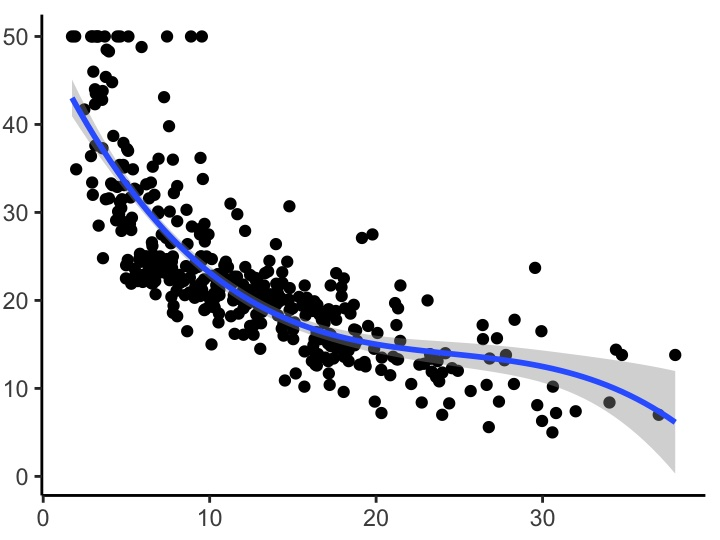
</center>


### Quantias para monitoramento

Antes de definirmos o laço principal de treinamento, vamos definir algumas quantias que gostaríamos de monitorar ao longo do treinamento em uma
função que recebe `q_func` e o `batch` atuais.

In [12]:
def special_values(q_func: LinearQFunction, batch: TensorDict) -> dict:
    """Retorna um dicionário com estatísticas calculadas utilizando um batch de experiências.
    
    Args:
        q_func: o aproximador da função valor-ação
        batch: conjunto de experiências em mini-batch
        
    Returns:
        Estatísticas contendo:
        * Valores de estados da distribuicao da politica
        * Valores de estados terminais por limite de tempo
        * Valores de estados terminais por angulo do poste
        * Valores de estados terminais por posicao horizontal
        * Valor do estado inicial perfeitamente centrado e equilibrado
        * Valores de estados fora da distribuicao da politica
    """
    # Angule do poste em que o episódio falha
    theta_threshold_radians = 12 * 2 * np.pi / 360
    # Posicao horizontal limite
    x_threshold = 2.4

    obs = batch["obs"]
    
    # Valores de estados da distribuicao da politica
    on_val = q_func(obs)
    on_val = tf.reduce_mean(on_val, axis=0)

    # Valores de estados terminais por limite de tempo
    timeout_obs = obs.copy()
    timeout_obs[..., -1] = 1
    timeout_val = q_func(timeout_obs)
    timeout_val = tf.reduce_mean(timeout_val, axis=0)
    
    # Valores de estados terminais por angulo do poste
    pole_fall = obs.copy()
    pole_fall[..., 2] = theta_threshold_radians
    fall_val = q_func(pole_fall)
    fall_val = tf.reduce_mean(fall_val, axis=0)

    # Valores de estados terminais por posicao horizontal
    off_screen = obs.copy()
    off_screen[..., 0] = x_threshold
    off_val = q_func(off_screen)
    off_val = tf.reduce_mean(off_val, axis=0)

    # Valor do estado inicial perfeitamente centrado e equilibrado
    init_obs = tf.convert_to_tensor([[0, 0, 0, 0, 0]], dtype=tf.float32)
    init_val = q_func(init_obs)[0]
    
    # Valores de estados fora da distribuicao da politica
    off_dist = np.expand_dims(q_func.observation_space.sample(), axis=0)
    off_val = q_func(off_dist)
    off_val = tf.reduce_mean(off_val, axis=0)
    
    stats = {
        "Q(timeout, <-)": timeout_val[0],
        "Q(timeout, ->)": timeout_val[1],
        "Q(fall, <-)": fall_val[0],
        "Q(fall, ->)": fall_val[1],
        "Q(off-screen, <-)": off_val[0],
        "Q(off-screen, ->)": off_val[1],
        "Q(initial, <-)": init_val[0],
        "Q(initial, ->)": init_val[1],   
        "Q(on-dist, <-)": on_val[0],
        "Q(on-dist, ->)": on_val[1],
        "Q(off-dist, <-)": off_val[0],
        "Q(off-dist, ->)": off_val[1]
    }
    return stats

### Laço de treinamento
Na função abaixo implementamos um laço de treinamento para um aproximador linear, política e conjunto de experiências da política.

Em `train` iteramos sobre o dataset amostrando _mini batches_, calculando o custo de predição via `prediction_loss` e atualizando os parâmetros do 
aproximador via `update_fn` (que utiliza `optimizer`)

In [13]:
def train(
    q_func: LinearQFunction, policy: Policy, dataset: TransitionDataset, n_iters: int,
    gamma: float = 1.0, learning_rate: float = 1e-3, batch_size: int = 32,
) -> str:
    # Logging
    timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")
    run_id = osp.join(
        f"{type(policy).__name__}-{q_func.name}".lower(), timestamp
    )
    logger = TFLogger(run_id, base_dir="logs/aula2")

    # Inicializacao de parametros, aproximadores e funcao custo
    input_spec = tf.TensorSpec(q_func.observation_space.shape, dtype=tf.float32)
    create_variables(q_func, input_spec)
    loss_fn = make_loss_fn(q_func, policy, gamma=gamma)
    update_fn = make_update_fn(loss_fn, q_func.trainable_variables, learning_rate=learning_rate)
    dataset.batch_size = batch_size
    
    for itr in trange(n_iters, desc="Training"):
        batch = dataset.sample()
        loss, grads_and_vars = update_fn(batch)

        stats = {
            "TD error": loss,
            "vars": {key: variable for key, (_, variable) in grads_and_vars.items()},
            "grads": {f"grad_{key}": grad for key, (grad, _) in grads_and_vars.items()},
        }
        stats.update(special_values(q_func, batch))

        logger.log(itr, stats, label="train")

---
## Visualizando a política e função valor

A função abaixo grava um vídeo da política no ambiente e os valores preditos pelo aproximador em cada estado.

Vamos testá-la com um aproximador não-aprendido por enquanto.

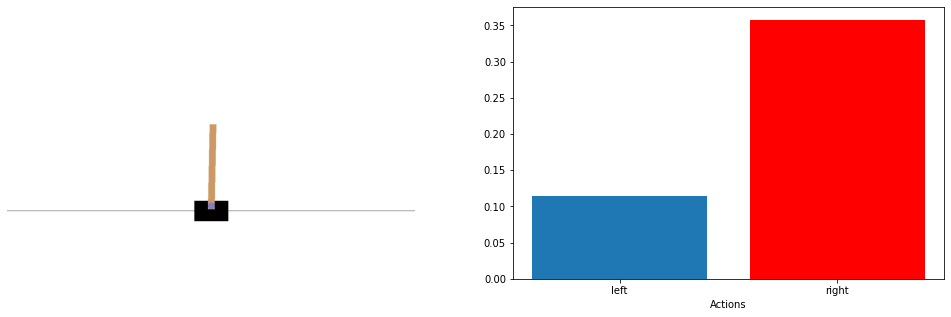

In [14]:
display_frames_and_q_values(env, policy, LinearQFunction(env.observation_space, env.action_space), actions=["left", "right"])

Podemos ver que a função inicializada aleatoriamente não é um bom preditor, vide valores negativos em um ambiente onde as recompensas são sempre positivas.

---
## Juntando os componentes e escolhendo a representação de features

Começamos por inicializar várias cópias do ambiente em paralelo para acelerar a coleta de dados.
Em seguida, construímos o dataset com a função `collect_data` definida anteriormente.

Na teoria, quanto mais dados da política disponíveis, melhor.

In [15]:
vec_env = gym.vector.make("CartPole-v0", num_envs=16, asynchronous=False, wrappers=TimeAwareWrapper)
dataset = collect_data(policy, vec_env, total_timesteps=200_000)

Collecting:   0%|          | 0/12500 [00:00<?, ?it/s]

### Tensorboard
A célula abaixo inicializa o `tensorboard`, um visualizador interativo das curvas de aprendizado e outras quantias que monitoramos na função `train`.

> **Dica**: você pode abrir `localhost:<port>`, onde `<port>` é 6006 ou informado depois de `--port` abaixo, para abrir o `tensorboard` em uma aba separada com mais espaço

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs/aula2 --reload_interval 10
# %tensorboard --logdir logs/aula2 --reload_interval 10 --port <port>

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1748), started 22:20:19 ago. (Use '!kill 1748' to kill it.)

### Aproximador linear simples

O próximo passo é escolher a representação de _features_ do estado e instanciar nosso aproximador linear, $Q_\phi(\mathbf{s, a})$, com base nela.
Vamos treinar um aproximador sem nenhuma representação especial de _features_, i.e., $f(\mathbf{s}) = \mathbf{s}$.

Finalmente, basta chamar a função `train` com o aproximador, a política e os dados coletados dela para executar o treinamento de 
$Q_\phi(\mathbf{s, a})$. Na teoria, quanto mais iterações (`n_iters`) dermos para o algoritmo, melhor.

In [17]:
q_func = LinearQFunction(env.observation_space, env.action_space)
train(q_func, policy, dataset, n_iters=500_000, learning_rate=1e-2)

Training:   0%|          | 0/500000 [00:00<?, ?it/s]

### Aproximador linear em _features_ senoidais do estado

Abaixo definimos uma função de representação que concatena ao estado funções seno e cosseno de suas variáveis. Isso pode ser útil para que o aproximador represente relações não-lineares das variáveis com o retorno esperado.

In [18]:
def senoidal_features(obs: tf.Tensor) -> tf.Tensor:
    # seno e cosseno das variaveis de estado
    sines = tf.sin(obs)
    cosines = tf.cos(obs)
    feat_vec = tf.concat([obs, sines, cosines], axis=-1)
    return feat_vec
    
sen_q = LinearQFunction(
    env.observation_space, 
    env.action_space, 
    features=senoidal_features, 
    name="SenoidalQ"
)
train(sen_q, policy, dataset, n_iters=500_000, learning_rate=1e-2)

Training:   0%|          | 0/500000 [00:00<?, ?it/s]

### Aproximador linear em _features_ polinomiais do estado

Abaixo definimos uma função de representação que concatena ao estado o produto de suas variáveis entre si. Isso pode ser útil para que o aproximador represente relações cruzadas entre variáveis e o retorno esperado.

In [19]:
def polynomial_features(obs: tf.Tensor) -> tf.Tensor:
    # de vetor (...xn) para vetor coluna (...xnx1)
    col = tf.expand_dims(obs, axis=-1)
    # produto externo entre os vetores coluna
    ext_prod = col @ tf.linalg.matrix_transpose(col)
    # selecionamos as entradas diagonais inferiores (superiores sao simetricas)
    feat_vec = tfp.math.fill_triangular_inverse(ext_prod)
    # variaveis finais sao a concatenacao das originais com as polinomiais
    feat_vec = tf.concat([obs, feat_vec], axis=-1)
    return feat_vec

poly_q = LinearQFunction(
    env.observation_space,
    env.action_space, 
    features=polynomial_features, 
    name="PolynomialQ"
)
train(poly_q, policy, dataset, n_iters=500_000, learning_rate=1e-2)

Training:   0%|          | 0/500000 [00:00<?, ?it/s]

---
## Conclusões

Os experimentos acima nos mostram algumas características importantes do problema de predição aproximada:
* Fazer predição perfeitamente é demorado e necessita de muitos dados
* Não é trivial escolher uma boa representação de _features_ mesmo conhecendo o ambiente
* Generalização para estados fora da distribuição da política é pobre

Nas próximas aulas veremos como superar esses obstáculos fazendo predição parcialmente, usando redes neurais para aprender representações complexas e aprendendo sobre exploração para cobertura maior do espaço de estados/ações do ambiente.

---
## Questões e experimentos

1. Teste o treinamento com as funções de _features_ não demonstradas em aula. Alguma delas proporciona resultados melhores que as outras?
2. Experimente políticas subótimas para predição instanciando `UniformRandomPolicy`, `HandCraftedCartPolePolicy` ou dando menos iterações para `get_cem_policy`
   * Lembre de coletar novamente um dataset com a política instanciada
   * Verifique se o aprendizado do aproximador é bem-sucecido, e.g., se os valores de estados iniciais coincide com o desempenho médio da política
3. Tente executar um treinamento mais intensivo, utilizando mais dados da política e executando mais iterações de gradiente descendente.
   1. Os valores aprendidos convergem para uma estimativa razoável?
   2. O _TD error_ começa a decrescer alguma hora?
4. Você consegue pensar em uma outra função de _features_ que ajude no aprendizado? Implemente e teste-a passando-a para `LinearQFunction`.

---
## Legacy code, not por publishing

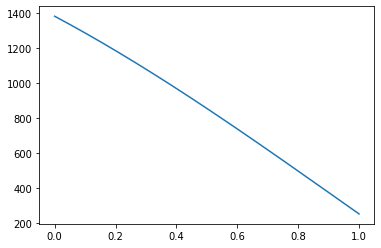

In [20]:
obs = np.zeros((1000, 4))
rel_time = np.linspace(0, 1.0, 1000)[..., None]
obs = np.concatenate((obs, rel_time), axis=-1)
obs = tf.convert_to_tensor(obs, dtype=tf.float32)

plt.plot(rel_time, sen_q(obs)[..., 0])
plt.show()

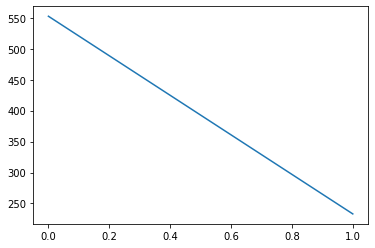

In [21]:
plt.plot(rel_time, q_func(obs)[..., 1])
plt.show()

In [22]:
sen_q.linear.w

<tf.Variable 'SenoidalQ/QValues/w:0' shape=(15, 2) dtype=float32, numpy=
array([[  38.32626 ,   43.671207],
       [ 107.83939 ,   99.34048 ],
       [  84.78029 ,   95.39947 ],
       [  66.38423 ,  115.94731 ],
       [-497.97006 , -493.5459  ],
       [  19.652868,   20.40899 ],
       [ 103.12009 ,   87.299805],
       [  84.80526 ,   95.018875],
       [  94.441055,   77.30237 ],
       [-428.47714 , -428.10532 ],
       [ 219.24072 ,  213.53226 ],
       [ 136.0685  ,  182.55693 ],
       [ 159.80019 ,  146.39569 ],
       [ 119.416626,   95.4215  ],
       [ 587.48676 ,  583.623   ]], dtype=float32)>

In [23]:
# def setup_checkpointing(run_id: str, q_func: LinearQFunction) -> tf.train.CheckpointManager:
#     ckpt_dir = osp.join("ckpt", run_id)
#     ckpt = tf.train.Checkpoint(q_func=q_func)
#     ckpt_manager = tf.train.CheckpointManager(ckpt, directory=ckpt_dir, max_to_keep=1)
#     return ckpt_manager

### Inicialização de parâmetros

Mais detalhes no inicializador na documentação do [VarianceScaling](https://sonnet.readthedocs.io/en/latest/api.html#sonnet.initializers.VarianceScaling)

In [24]:
# def he_initializer():
#     return snt.initializers.VarianceScaling(scale=2.0, mode="fan_in", distribution="uniform")